# Training Distributions with KM Divergence

Short tutorial on how to form objectives like in this paper  
https://arxiv.org/pdf/1801.07686.pdf

First some imports and the advice to use `tq.numpy` for functions in objectives (avoid issues in automatic differentiations and use the regular `numpy` for everything else (avoid issues with jax where you don't want them)

In [1]:
import tequila as tq
import numpy

First we define the $\max(x,\epsilon)$ function we will need further down the road and some global variables for this example

In [2]:
# global variables, change here if you want
eps = 1.e-8
n_qubits = 5
n_layers = 1

def my_max(x):
    if x<eps:
        return eps
    else:
        return x

In this example we will train for the generation of GHZ state (as in the paper above).  
The ansatz template consists of `Rx` gates and Mølmer-Sørensen gates which are just rotations around XX.  
We give here the option of using multiple layers, but one layer actually suffices for this example

In [3]:
# create ansatz
U = tq.QCircuit()
for layer in range(n_layers):
    for q in range(n_qubits):
        # name can be any non-numeric hashable type
        # scaling variables with pi in this example
        variable = tq.Variable(name=(layer, q))
        U += tq.gates.Rx(angle=variable*tq.numpy.pi, target=q)
    for q in range(n_qubits):
        for p in range(q+1, n_qubits):
            U += tq.gates.ExpPauli(angle=tq.numpy.pi / 2.0, paulistring="X({})X({})".format(q, p))

Here are some demonstrations on how to extract informations from your template circuit U

In [4]:
print(U)
print("Circuit depends on variables: ", U.extract_variables())

circuit: 
Rx(target=(0,), parameter=Objective with 0 unique expectation values
variables = [(0, 0)]
types     = [])
Rx(target=(1,), parameter=Objective with 0 unique expectation values
variables = [(0, 1)]
types     = [])
Rx(target=(2,), parameter=Objective with 0 unique expectation values
variables = [(0, 2)]
types     = [])
Rx(target=(3,), parameter=Objective with 0 unique expectation values
variables = [(0, 3)]
types     = [])
Rx(target=(4,), parameter=Objective with 0 unique expectation values
variables = [(0, 4)]
types     = [])
Exp-Pauli(target=(0, 1), control=(), parameter=1.5707963267948966, paulistring=X(0)X(1))
Exp-Pauli(target=(0, 2), control=(), parameter=1.5707963267948966, paulistring=X(0)X(2))
Exp-Pauli(target=(0, 3), control=(), parameter=1.5707963267948966, paulistring=X(0)X(3))
Exp-Pauli(target=(0, 4), control=(), parameter=1.5707963267948966, paulistring=X(0)X(4))
Exp-Pauli(target=(1, 2), control=(), parameter=1.5707963267948966, paulistring=X(1)X(2))
Exp-Pauli(targe

The circuit is parametrized by variables, so if we want to simulate it we will have to choose for which values we want to simulate the wavefunction. Here is an example where we set all variables to $\pi$.  
Variables are passed down to the simulator as a dictionary holding the variable names and values

In [5]:
variables = {k : 1.0 for k in U.extract_variables()}
wfn = tq.simulate(U, variables=variables)
print("wfn with variables = ", variables)
print(wfn)

wfn with variables =  {(0, 0): 1.0, (0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (0, 4): 1.0}
+0.2500|10000> +0.2500|01000> +0.2500|00100> -0.2500|11100> +0.2500|00010> -0.2500|11010> -0.2500|10110> -0.2500|01110> +0.2500|00001> -0.2500|11001> -0.2500|10101> -0.2500|01101> -0.2500|10011> -0.2500|01011> -0.2500|00111> +0.2500|11111> 


Instead of simulating directly the circuit can also be compiled and afterwards be used like a function

In [6]:
compiledU = tq.compile(U)
wfn = compiledU(variables=variables)
print(wfn)

+0.2500|10000> +0.2500|01000> +0.2500|00100> -0.2500|11100> +0.2500|00010> -0.2500|11010> -0.2500|10110> -0.2500|01110> +0.2500|00001> -0.2500|11001> -0.2500|10101> -0.2500|01101> -0.2500|10011> -0.2500|01011> -0.2500|00111> +0.2500|11111> 


Next we will define the target distribution which we want to optimize for. It is the distribution of a GHZ state, i.e. $P(00..0) = 0.5$ and $P(11..1)=0.5$ where in the following we will use binary notation for easier coding i.e $00...0=0$ and $11..1=2^{n-1}+2^{n-2}+..+1$

In [7]:
one = sum([2**i for i in range(n_qubits)])
target_distribution = {0:0.5, one:0.5}

For the tequila objective Born's rule will be used. In order to make this work we need to reformulate this as an expectation value. This can be achieved as 
$$\displaystyle \lvert\langle ijk..l \rvert \Psi \rangle\rvert^2 = \langle \Psi \rvert H \lvert \Psi \rangle$$
where $i,j,k..,l \in \left\{0,1 \right\}$ and the Hamiltonian is
$$ \displaystyle H = \lvert ijk..l \rangle \langle ijk..l \rvert = \otimes_{m \in (ijk..l)} \frac{1}{n}\left( 1 + (-1)^{m}\sigma_Z \right)$$

Tequila has a convenience shortcut for the operator $$Q_{\pm} = \frac{1}{2}\left( 1 \pm \sigma_Z \right) $$

Lets build the Kullback–Leibler divergence of the distribution P generated by our template U and the target distribution Q

$$ \displaystyle D(P,Q) = -\frac{1}{2^n} \sum_{x} P(x) \ln\left(\frac{P(x)}{Q(x)}\right) $$

where we use the same safety barrier as in the paper to prevent taking logarithms of zero (this is where the mymax function fron above is needed). In the end we will square the objective to avoid negative values and assure that zero is the minimum.

In [8]:
objective = tq.Objective()

for k, Q in target_distribution.items():
    Q = my_max(Q) # here we apply the mymax function to avoid having zeros
    wfn = tq.QubitWaveFunction.from_int(k, n_qubits=n_qubits)
    H = tq.paulis.Projector(wfn=wfn)
    P = tq.ExpectationValue(H=H, U=U)  # this is the born rule expectation value from above
    P = P.apply(my_max) # here we apply the mymax function to avoid having zeros
    objective += Q*(Q / P).apply(tq.numpy.log) # here we take the logarithm and sum up
    
objective = 1.0/2.0**n_qubits *objective
objective = objective**2 # here we take the square

Lets see what we created here.
Tequila created an objective with 4 expectationvalues (we had 2 values in the target_distribution, and P entered twice each) but only 2 unique expectationvalues (meaning the simulator will only evaluate those two)

In [9]:
print(objective)

Objective with 2 unique expectation values
variables = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
types     = not compiled


Objectives can be compiled and simulated in the same way as the circuits above. 
Here is a small demonstration.  
Since our objective is parametrized we need to pass the variables down again. We will use the same as in the example above.


In [10]:
value1 = tq.simulate(objective, variables=variables)
compiled = tq.compile(objective)
value2 = compiled(variables=variables)
variables2 = {k:1.1 for k in objective.extract_variables()}
value3 = compiled(variables=variables2)
print("value1 = ", value1)
print("value2 = ", value2)
print("value3 = ", value3)

value1 =  0.09578033
value2 =  0.09578033
value3 =  0.004561313


Lets optimize our objective with one of the inbuildt optimizers in tequila.  
If no initial_values are passed down, random initialization will be used.  
Check the OptimizerSciPy Tutorial for more information

In [11]:
result = tq.optimizer_scipy.minimize(objective=objective, method="Cobyla")

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues

active variables : 5

E=+0.02747765  angles= {(0, 0): 1.196973294671848, (0, 1): 3.487261445909955, (0, 2): 1.2546004948085328, (0, 3): 4.323339379115283, (0, 4): 4.297460215759149}  samples= None
E=+0.04326624  angles= {(0, 0): 2.196973294671848, (0, 1): 3.487261445909955, (0, 2): 1.2546004948085328, (0, 3): 4.323339379115283, (0, 4): 4.297460215759149}  samples= None
E=+0.01335919  angles= {(0, 0): 1.196973294671848, (0, 1): 4.4872614459099545, (0, 2): 1.2546004948085328, (0, 3): 4.323339379115283, (0, 4): 4.297460215759149}  samples= None
E=+0.00350544  angles= {(0, 0): 1.196973294671848, (0, 1): 4.4872614459099545, (0, 2): 2.2546004948085328, (0, 3): 4.323339379115283, (0, 4): 4.297460215759149}  samples= None
E=+0.01896261  angles=

E=+0.00000000  angles= {(0, 0): 0.5013061597176728, (0, 1): 4.4960270840878, (0, 2): 2.48566776555843, (0, 3): 4.503869897155823, (0, 4): 4.502714829363983}  samples= None
E=+0.00000000  angles= {(0, 0): 0.5029198512608419, (0, 1): 4.492672827965057, (0, 2): 2.493668010701275, (0, 3): 4.503215745083131, (0, 4): 4.501067936759923}  samples= None
E=+0.00000000  angles= {(0, 0): 0.5010813367874862, (0, 1): 4.486658600996661, (0, 2): 2.4982437752170585, (0, 3): 4.502987542012001, (0, 4): 4.500364802911858}  samples= None
E=+0.00000000  angles= {(0, 0): 0.5050821929857228, (0, 1): 4.4913470678686, (0, 2): 2.493017039272258, (0, 3): 4.506066486124667, (0, 4): 4.501592283216655}  samples= None
E=+0.00000000  angles= {(0, 0): 0.5077514527347123, (0, 1): 4.494003301783319, (0, 2): 2.494760747894221, (0, 3): 4.497595579045114, (0, 4): 4.499295852676457}  samples= None
E=+0.00000000  angles= {(0, 0): 0.5018493108267006, (0, 1): 4.4982290636498865, (0, 2): 2.49878720103826, (0, 3): 4.5045499968647

Lets compute our wavefunction with the optimized angles

In [12]:
final_wfn = tq.simulate(U, variables=result.angles)
print(final_wfn)

-0.7071i|00000> +0.0001|01000> +0.0006|00100> -0.0002|00010> -0.0002i|11110> +0.0002|00001> +0.0002i|11101> -0.0006i|11011> -0.0001i|10111> -0.7071|11111> 


And plot some information about the optimization 

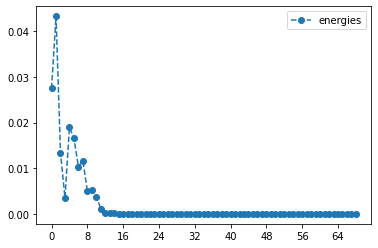

In [13]:
result.history.plot("energies")

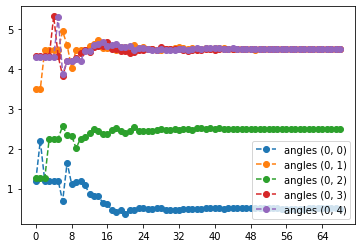

In [14]:
result.history.plot("angles")